# Baseball batting average estimation

One of the primary goals in sports analytics is separating talent or skill from random chance when interpreting observed outcomes. While we ultimately care about outcomes (games won, points scored, base hits), it is only the skill associated with the player or team that is useful in predicting future outcomes. This is certainly the case in baseball, where even very good players can have lengthy spells without getting a hit, and likewise, below-average players can go on hitting streaks.

The following example, taken from Efron and Morris (1975) illustrates this point: the data comprise 18 batters that have, by a particular date in the 1970 season, accumulated 45 at bats (chances to get a hit). The number of hits range from 7 to 18. Yet, how can we be sure that the players with more hits are more skilled than those with fewer? We can use a Bayesian modeling approach to estimate the batting averages (the expected proportion of at bats that result in hits) for the players, using partial pooling to adjust extreme values, thereby hedging our bets where luck may have been at play.

In [1]:
import arviz as az
import pymc4 as pm
import tensorflow as tf
import pandas as pd

In [3]:
data = pd.read_csv(pm.utils.get_data('efron-morris-75-data.tsv'), sep="\t")
at_bats, hits = data[['At-Bats', 'Hits']].values.T

In [4]:
data.iloc[:, :4].head()

,FirstName,LastName,At-Bats,Hits
0,Roberto,Clemente,45,18
1,Frank,Robinson,45,17
2,Frank,Howard,45,16
3,Jay,Johnstone,45,15
4,Ken,Berry,45,14


Since batting data can be modeled as a Binomial process, with the number of at bats as the sample size and the number of hits as the count of events. The naive approach to estimating the latent batting average for each player would be to assign independent priors for each player, but this would not do an adequate job of accounting for luck for players with extreme numbers of events. Instead, we want to constrain the hit probabilities by modeling the population of batting averages, using a hierarchical model.

A natural hierarchical model for binomial probabilities is the beta distribution. Here, we will use a reparameterization of the beta, which uses the mean probability ($\phi$) and variance ($\kappa$), which are related to the shape and scale parameters more commonly used with beta distributions as follows:

$$\alpha = \phi \kappa$$

$$\beta = (1 - \phi) \kappa$$

Here is the hierarchical binomial model in PyMC4:

In [5]:
N = len(hits)

@pm.model
def baseball_model():
    # Population mean batting average
    phi = yield pm.Uniform("phi", 0, 1)
    
    # Population batting average variance
    kappa_log = yield pm.Exponential('kappa_log', rate=1.5)
    kappa = yield pm.Deterministic('kappa', tf.math.exp(kappa_log))
    
    # Latent batting average for each player
    thetas = yield pm.Beta('thetas', phi * kappa, (1 - phi) * kappa, plate=N)
    y = yield pm.Binomial('y', total_count=tf.constant(at_bats, dtype=tf.float32), probs=thetas, observed=tf.constant(hits, dtype=tf.float32))

In [6]:
%time trace =  pm.inference.utils.trace_to_arviz(*pm.inference.sampling.sample(baseball_model(), num_chains=128))

CPU times: user 4min 24s, sys: 28.2 s, total: 4min 53s
Wall time: 1min 59s


If we plot the posterior estimates alongside the maximum likelihood estimates, we can see the shrinkage that the hierarchical model has imposed. The highest batting averages are still the largest, but are not unrealistically large (there has not been a .400 hitter since the 1940s), while the lowest averages are similarly pulled toward the population mean.

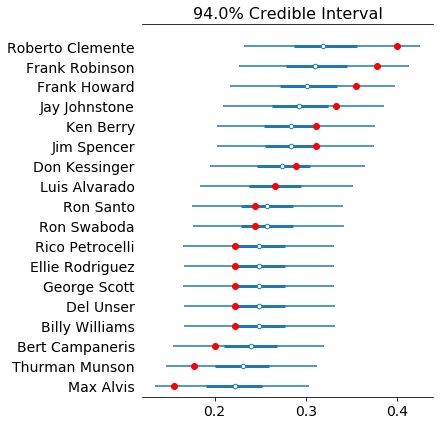

In [7]:
player_names = data.apply(lambda x: x.FirstName + ' ' + x.LastName, axis=1)
ax = az.plot_forest(trace, var_names='baseball_model/thetas', combined=True)
ax[0].set_yticklabels(player_names.tolist()[-1::-1])
ax[0].plot((hits/at_bats)[::-1], ax[0].get_yticks(), 'ro');

We can also look at other interesting posterior quantities. For example, what's the probability the batter with the highest average (Roberto Clemente) has a true hit probability that is higher than the batter with the lowest average (Max Alvis).

In [8]:
clemente = trace.posterior['baseball_model/thetas'].values[..., 0].flatten()
alvis = trace.posterior['baseball_model/thetas'].values[..., -1].flatten()

In [9]:
(clemente > alvis).mean()

0.941328125

So, we are confident that Clemente (who is in the baseball Hall of Fame) is a better hitter than Alvis. In fact, at the end of the 1970 season Clemente had a .352 batting average (in 412 at bats) while Alvis finished with a .183 average (115 at bats).